In [73]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nutritional-values-for-common-foods-and-products/nutrition.csv


**Импортируем дополнительные библиотеки**

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

**Загружаем dataset и проверям загрузку**

In [75]:
try:
    df = pd.read_csv('/kaggle/input/nutritional-values-for-common-foods-and-products/nutrition.csv')
    print("Данные успешно загружены. Доступно колонок:", len(df.columns))
except FileNotFoundError:
    print("Ошибка: Файл не найден. Проверьте путь к файлу.")
    exit()

Данные успешно загружены. Доступно колонок: 77


**Делаем первычный осмотр данных первых 5 строк и просмотр информации о данных**

In [77]:
print(f"Размер датасета: {df.shape}")
print("\nПервые 5 строк:")
display(df.head())
print("\nИнформация о данных:")
df.info()

Размер датасета: (8789, 77)

Первые 5 строк:


,Unnamed: 0,name,serving_size,calories,total_fat,saturated_fat,cholesterol,sodium,choline,folate,...,fat,saturated_fatty_acids,monounsaturated_fatty_acids,polyunsaturated_fatty_acids,fatty_acids_total_trans,alcohol,ash,caffeine,theobromine,water
0,0,Cornstarch,100 g,381,0.1g,NaN,0,9.00 mg,0.4 mg,0.00 mcg,...,0.05 g,0.009 g,0.016 g,0.025 g,0.00 mg,0.0 g,0.09 g,0.00 mg,0.00 mg,8.32 g
1,1,"Nuts, pecans",100 g,691,72g,6.2g,0,0.00 mg,40.5 mg,22.00 mcg,...,71.97 g,6.180 g,40.801 g,21.614 g,0.00 mg,0.0 g,1.49 g,0.00 mg,0.00 mg,3.52 g
2,2,"Eggplant, raw",100 g,25,0.2g,NaN,0,2.00 mg,6.9 mg,22.00 mcg,...,0.18 g,0.034 g,0.016 g,0.076 g,0.00 mg,0.0 g,0.66 g,0.00 mg,0.00 mg,92.30 g
3,3,"Teff, uncooked",100 g,367,2.4g,0.4g,0,12.00 mg,13.1 mg,0,...,2.38 g,0.449 g,0.589 g,1.071 g,0,0,2.37 g,0,0,8.82 g
4,4,"Sherbet, orange",100 g,144,2g,1.2g,1mg,46.00 mg,7.7 mg,4.00 mcg,...,2.00 g,1.160 g,0.530 g,0.080 g,1.00 mg,0.0 g,0.40 g,0.00 mg,0.00 mg,66.10 g



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8789 entries, 0 to 8788
Data columns (total 77 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Unnamed: 0                   8789 non-null   int64 
 1   name                         8789 non-null   object
 2   serving_size                 8789 non-null   object
 3   calories                     8789 non-null   int64 
 4   total_fat                    8789 non-null   object
 5   saturated_fat                7199 non-null   object
 6   cholesterol                  8789 non-null   object
 7   sodium                       8789 non-null   object
 8   choline                      8789 non-null   object
 9   folate                       8789 non-null   object
 10  folic_acid                   8789 non-null   object
 11  niacin                       8789 non-null   object
 12  pantothenic_acid             8789 non-null   object
 13  riboflavin 

Первые 5 строк показывают, что у нас есть информация о продуктах, их калорийности и содержании различных питательных веществ.

**Делаем проверку пропущенных значений и выводим даннные на тепловой карте**

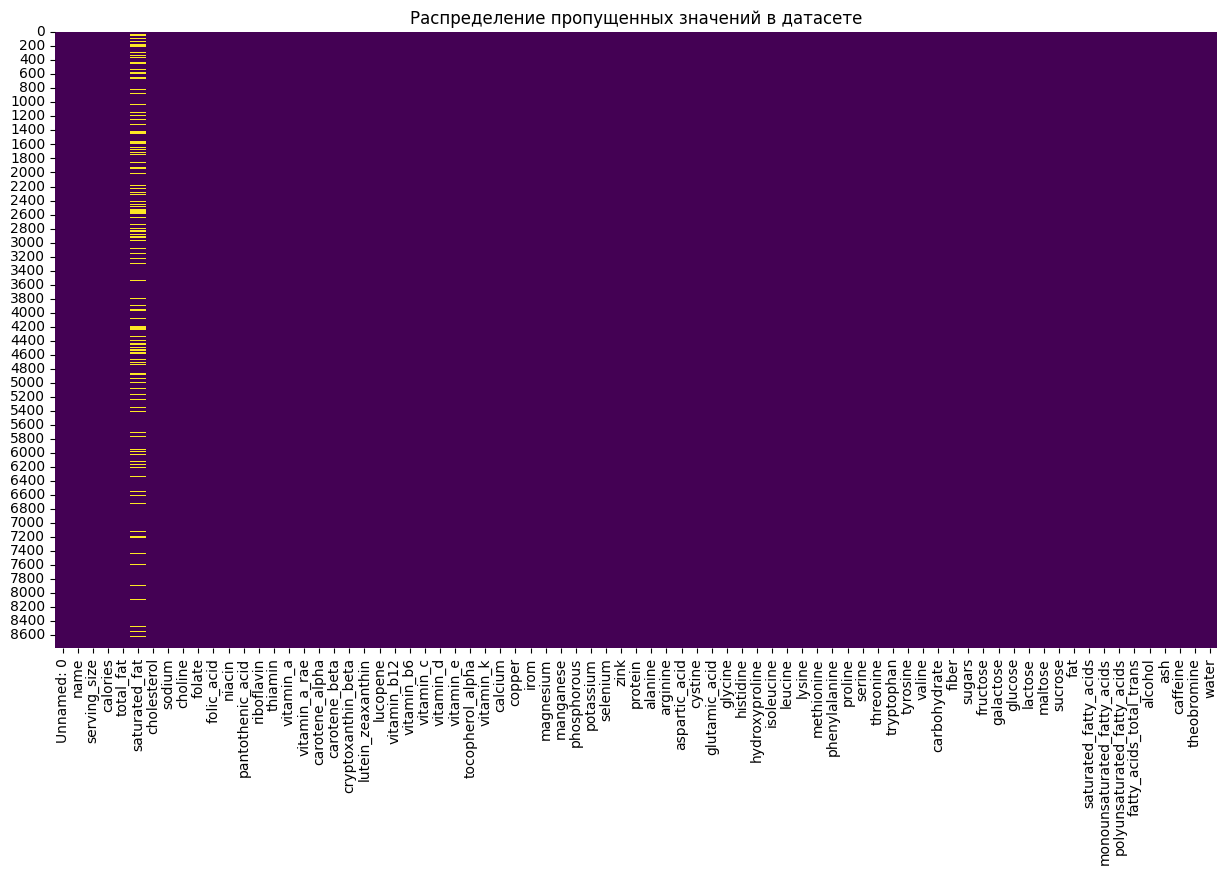

In [78]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Распределение пропущенных значений в датасете')
plt.show()

На тепловой карте видно, что некоторые колонки содержат много пропущенных значений. Для анализа, который буду делать я необходимы колонки с питательными веществами, которые имеют меньше пропусков.

**Очистка числовых значений от единиц измерения**

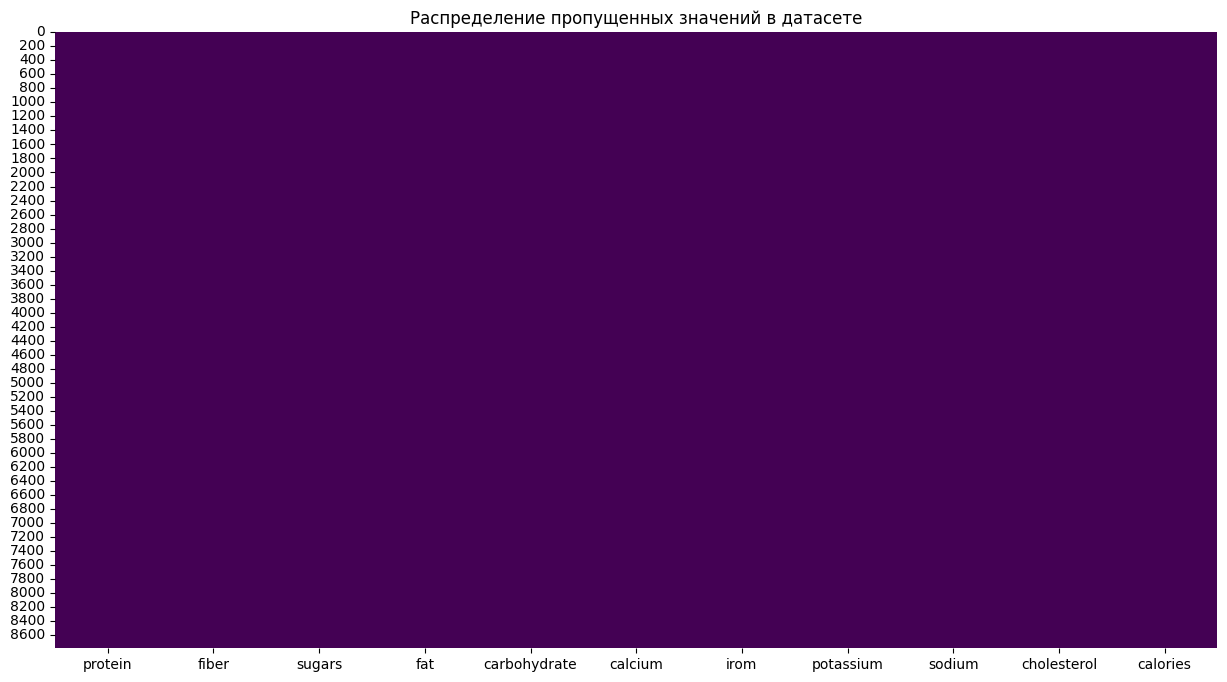

In [88]:
def clean_numeric(value):
    if isinstance(value, str):
        cleaned = ''.join(c for c in value if c.isdigit() or c in {'.', '-'})
        return float(cleaned) if cleaned else np.nan
    return value

nutrients = ['protein', 'fiber', 'sugars', 'fat', 'carbohydrate', 
             'calcium', 'irom', 'potassium', 'sodium', 'cholesterol', 'calories']

df_clean = df.copy()
for col in nutrients:
    df_clean[col] = df_clean[col].apply(clean_numeric)

plt.figure(figsize=(15, 8))
sns.heatmap(df_clean[nutrients].isnull(), cbar=False, cmap='viridis')
plt.title('Распределение пропущенных значений в датасете')
plt.show()

df_clean = df_clean.dropna(subset=['calories'] + nutrients[:-1])

Создана функция для очистки числовых значений от единиw измерения, в ней мы удаляем все нечисловые значения кроме точки и минуса. Очищаем все столбцы которые нам понадобятся для вычисления корреляции. Далее делаем анализ пропущенных значений и делаем удаление строк с пропусками в целевой переменной и основных нутриентах.

**Анализ распределения калорий**

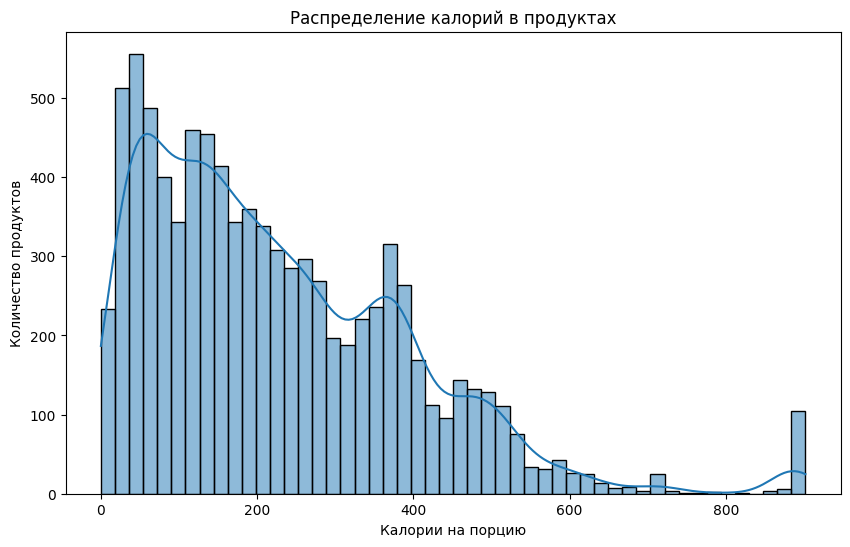

In [79]:
plt.figure(figsize=(10, 6))
sns.histplot(df['calories'], bins=50, kde=True)
plt.title('Распределение калорий в продуктах')
plt.xlabel('Калории на порцию')
plt.ylabel('Количество продуктов')
plt.show()

Распределение калорий правостороннее с длинным хвостом. Большинство продуктов содержат от 0 до 500 калорий на порцию, но есть выбросы с очень высокой калорийностью.

**Корреляция питательных веществ с калориями**

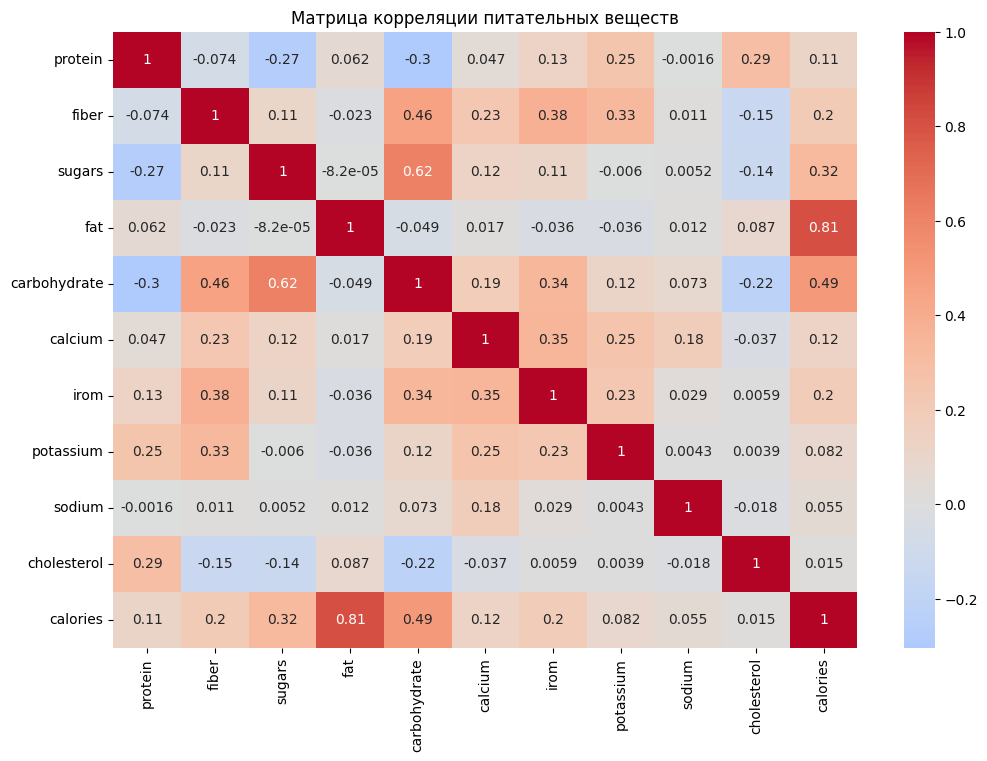

In [90]:
corr_matrix = df_clean[nutrients].corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции питательных веществ')
plt.show()

**Анализ корреляции с целефой переменной**

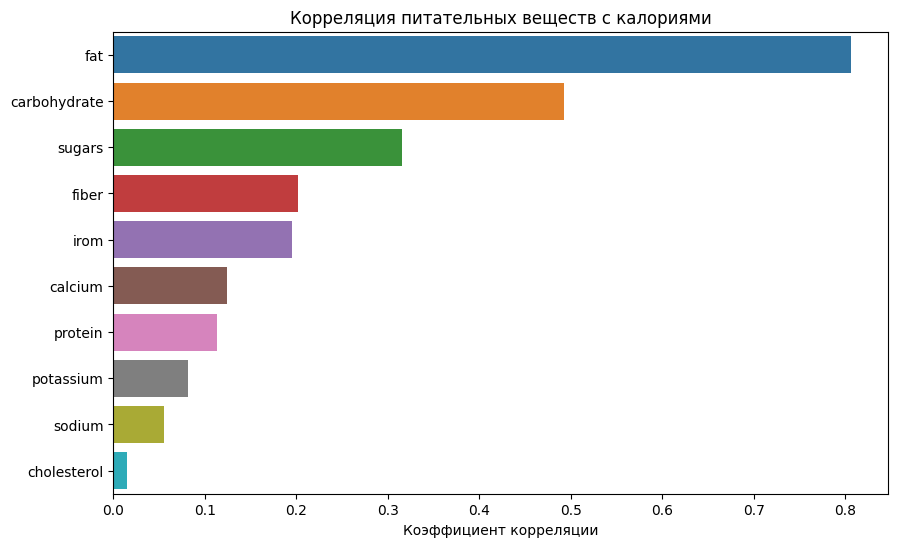

In [91]:
corr_with_calories = corr_matrix['calories'].sort_values(ascending=False)[1:]
plt.figure(figsize=(10, 6))
sns.barplot(x=corr_with_calories.values, y=corr_with_calories.index)
plt.title('Корреляция питательных веществ с калориями')
plt.xlabel('Коэффициент корреляции')
plt.show()

Наибольшую положительную корреляцию с калориями имеют жиры (fat), углеводы (carbohydrate) и белки (protein). Это ожидаемо, так как эти макронутриенты являются основными источниками калорий.

Создание нового признака **"Плотность питательных веществ"**

In [93]:
df_clean['nutrient_density'] = (df_clean['protein'] + df_clean['fiber'] + 
                               df_clean['calcium'] + df_clean['potassium']) / df_clean['calories']
df_clean['protein_efficiency'] = df_clean['protein'] / df_clean['calories']
df_clean['fiber_efficiency'] = df_clean['fiber'] / df_clean['calories']

**Топ-10 продуктов по плотности питптельных веществ**

In [94]:
top_nutrient_dense = df_clean.sort_values('nutrient_density', ascending=False).head(10)[['name', 'nutrient_density', 'calories']]
print("\nТоп-10 продуктов по плотности питательных веществ:")
display(top_nutrient_dense)


Топ-10 продуктов по плотности питательных веществ:


,name,nutrient_density,calories
7721,"Beverages,,Gerolsteiner naturally sparkling mi...",inf,0
1776,"Beverages, brewed, hibiscus, tea",inf,0
1780,"Beverages, drinking, tap, water",inf,0
619,"Salt, table",inf,0
7495,"Beverages, contains caffeine, with sodium sacc...",inf,0
7024,"Beverages, without caffeine, other than cola ...",inf,0
2064,"Beverages, POLAND SPRING, bottled, water",inf,0
8053,"Beverages, fortified, Revive Fruit Punch, Glac...",inf,0
7593,"Beverages, contains caffeine, with aspartame, ...",inf,0
1753,"Beverages, club soda, carbonated",inf,0


**Подготовка данных для анализа пищевой ценности продуктов.**

In [99]:
nutrients = ['protein', 'fiber', 'sugars', 'fat', 'carbohydrate', 
             'calcium', 'irom', 'potassium', 'sodium', 'cholesterol', 'calories']

df_clean = df.copy()
for col in nutrients:
    df_clean[col] = df_clean[col].apply(clean_numeric)

df_clean = df_clean.dropna(subset=['calories'] + nutrients[:-1])

def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

df_clean['nutrient_density'] = safe_divide(
    (df_clean['protein'] + df_clean['fiber'] + df_clean['calcium'] + df_clean['potassium']),
    df_clean['calories']
)

df_clean['protein_efficiency'] = safe_divide(df_clean['protein'], df_clean['calories'])
df_clean['fiber_efficiency'] = safe_divide(df_clean['fiber'], df_clean['calories'])

df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
df_clean = df_clean.dropna(subset=['nutrient_density', 'protein_efficiency', 'fiber_efficiency'])

features = ['protein', 'fiber', 'fat', 'carbohydrate', 'calcium', 
            'irom', 'potassium', 'nutrient_density', 'protein_efficiency', 'fiber_efficiency']
X = df_clean[features]
y = df_clean['calories']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Код преобразует сырые данные о питательной ценности в очищенный и подготовленный набор данных. Код готов для обучения моделей машинного обучения, с созданными новыми информативными признаками.

**Создание функции для вычисления модели**

In [102]:
def evaluate_model(model, X, y, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    print(f"\n{model_name} Performance:")
    print(f"R2 Score: {r2_scores.mean():.3f} (±{r2_scores.std():.3f})")
    print(f"MSE: {mse_scores.mean():.3f} (±{mse_scores.std():.3f})")

**Добавление импортов для нейронной сети**

In [110]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import KFold  

def evaluate_model(model, X, y, model_name):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring='r2')
    mse_scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    
    print(f"\n{model_name} Performance:")
    print(f"R2 Score: {r2_scores.mean():.3f} (±{r2_scores.std():.3f})")
    print(f"MSE: {mse_scores.mean():.3f} (±{mse_scores.std():.3f})")
    
    model.fit(X_train, y_train)
    
    if hasattr(model, 'feature_importances_'):
        plt.figure(figsize=(10, 6))
        feat_importances = pd.Series(model.feature_importances_, index=features)
        feat_importances.nlargest(10).plot(kind='barh')
        plt.title(f'Feature Importance ({model_name})')
        plt.show()
    
    return model

**Обучение разных типов модели**


Linear Regression Performance:
R2 Score: 0.992 (±0.003)
MSE: 238.772 (±85.955)

Random Forest Performance:
R2 Score: 0.993 (±0.001)
MSE: 205.121 (±36.680)


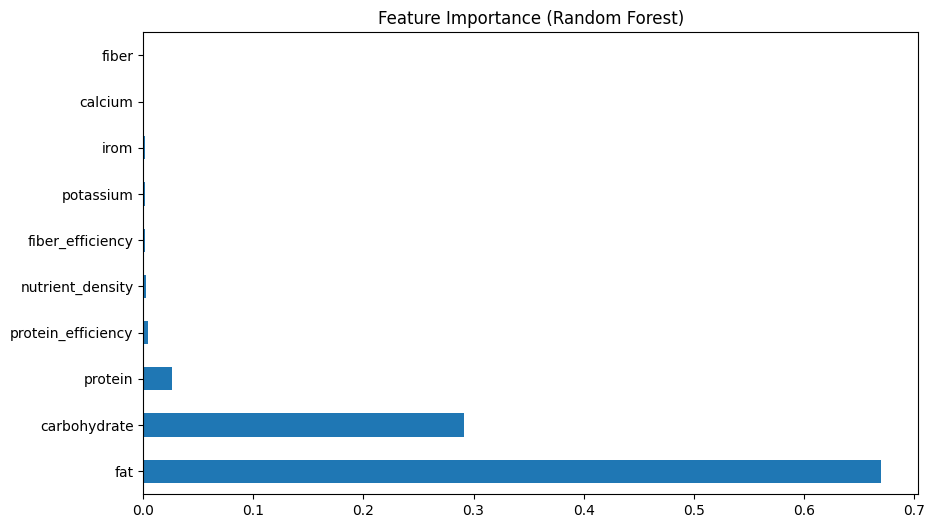


XGBoost Performance:
R2 Score: 0.993 (±0.001)
MSE: 188.527 (±32.880)


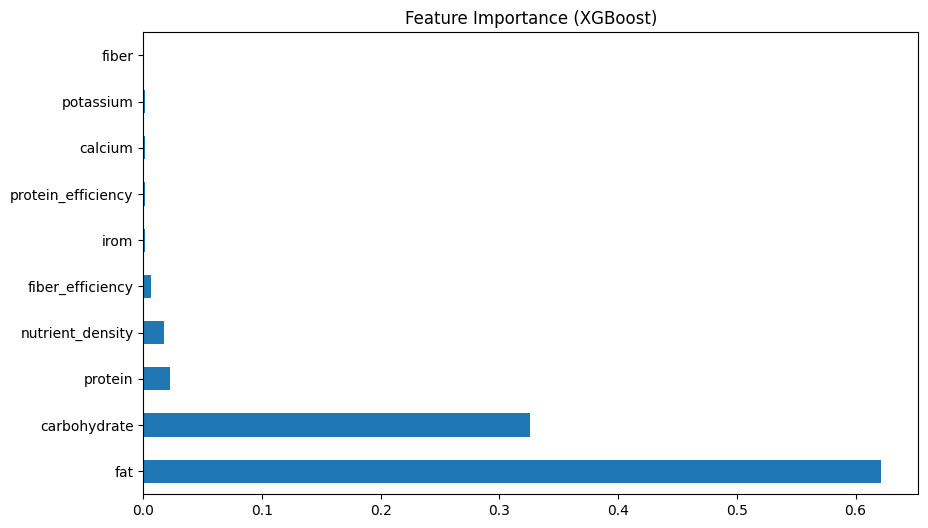


Neural Network Performance:
R2 Score: 0.993 (±0.003)
MSE: 200.219 (±68.405)

Final Results for Best Model (XGBoost) on Test Set:
R2 Score: 0.994
MSE: 167.464


In [111]:
# Линейная регрессия
lr = LinearRegression()
lr = evaluate_model(lr, X_scaled, y, "Linear Regression")

# Случайный лес
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf = evaluate_model(rf, X_scaled, y, "Random Forest")

# XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42)
xgb_model = evaluate_model(xgb_model, X_scaled, y, "XGBoost")

# Нейронная сеть (теперь с правильным импортом)
nn = MLPRegressor(hidden_layer_sizes=(50, 50), 
                 max_iter=500, 
                 random_state=42,
                 early_stopping=True)  # Добавляем early_stopping для стабильности
nn = evaluate_model(nn, X_scaled, y, "Neural Network")

# Вывод результатов
best_model = xgb_model  # Предполагаем, что XGBoost показал лучшие результаты
y_pred = best_model.predict(X_test)
final_r2 = r2_score(y_test, y_pred)
final_mse = mean_squared_error(y_test, y_pred)

print("\nFinal Results for Best Model (XGBoost) on Test Set:")
print(f"R2 Score: {final_r2:.3f}")
print(f"MSE: {final_mse:.3f}")

1. Обучаются 4 принципиально разных типа моделей
2. Для каждой оценивается качество с помощью кросс-валидации
3. Выбирается лучшая модель по заданным метрикам
4. Оценивается ее работа на тестовых данных
5. Выводятся итоговые показатели качества предсказаний

**Визуализация предсказаний и реальных значений**

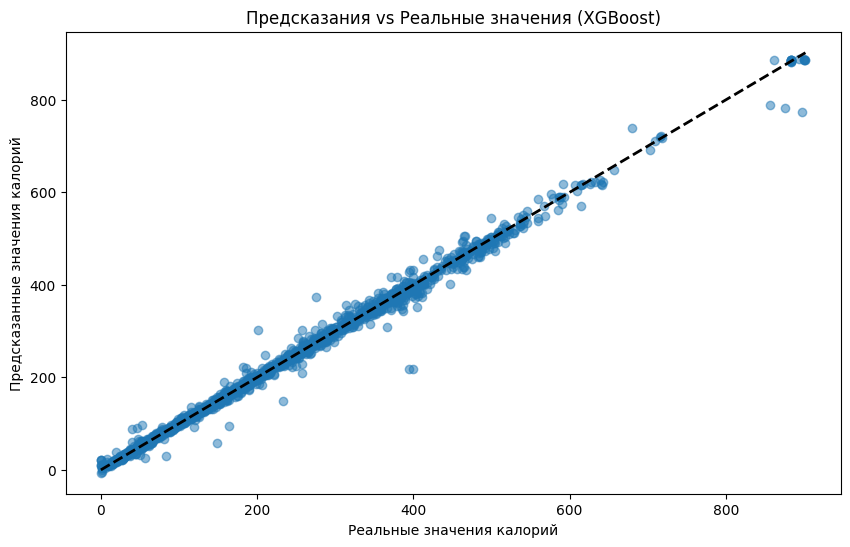

In [112]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Реальные значения калорий')
plt.ylabel('Предсказанные значения калорий')
plt.title('Предсказания vs Реальные значения (XGBoost)')
plt.show()

**Рекомендации по продуктам с лучшим соотношением полезных веществ**

In [113]:
df_clean['predicted_calories'] = best_model.predict(X_scaled)
df_clean['calorie_efficiency'] = df_clean['nutrient_density'] / df_clean['predicted_calories']

recommended_products = df_clean.sort_values('calorie_efficiency', ascending=False).head(20)[['name', 'calories', 'nutrient_density', 'calorie_efficiency']]
print("\nТоп-20 рекомендуемых продуктов с лучшим соотношением полезных веществ к калориям:")
display(recommended_products)


Топ-20 рекомендуемых продуктов с лучшим соотношением полезных веществ к калориям:


,name,calories,nutrient_density,calorie_efficiency
5618,"Beverages, prepared with water, decaffeinated,...",2,20.060000,480.618773
4572,"Beverages, prepared with tap water, brewed, co...",1,51.120000,85.261421
3958,"Mollusks, liquid, canned, mixed species, clam",2,81.200000,28.200193
5908,"Beverages, prepared with distilled water, brew...",1,21.000000,25.412734
4185,"Beverages, unsweetened, ready-to-drink, tea, W...",1,16.220000,16.007971
5034,"Beverages, prepared with water, regular, insta...",2,17.050000,13.698698
4990,"Beverages, prepared with water, unsweetened, i...",1,21.060000,12.194571
359,"Butterbur, canned",3,15.370000,11.528819
4496,"Beverages, diet, lemon, ready-to-drink, black,...",1,14.000000,11.285575
3171,"Beverages, breakfast blend, brewed, coffee",2,26.150000,10.797723
